In [0]:
# instruction of using colab python 
# https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [107]:
from google.colab import drive
drive.mount('/content/drive/')
# 4/oQAe5a98SL9kZzGrY2QyFGlcPFGy4wN4gZZ1O8R4y4zXhhJWJ0KnGT4

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [108]:
import os
os.chdir("/content/drive/My Drive/UdeM/ML/project")
#check if you are in the right directory
!ls

Auto_run_data_process.ipynb  data-FM  encoder.txt
Auto_run.ipynb		     data-IP  utils


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix 
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
import sklearn as skl
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Import Data

In [0]:
train_df = pd.read_table(
    'data-IP/adult.data',sep = ',',
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        engine='python',
        na_values="?")
#train_df.head()
test_df = pd.read_table('data-IP/adult.test',sep = ',',
        names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        engine='python',
        skiprows=[0],
        na_values="?")
#test_df.head()

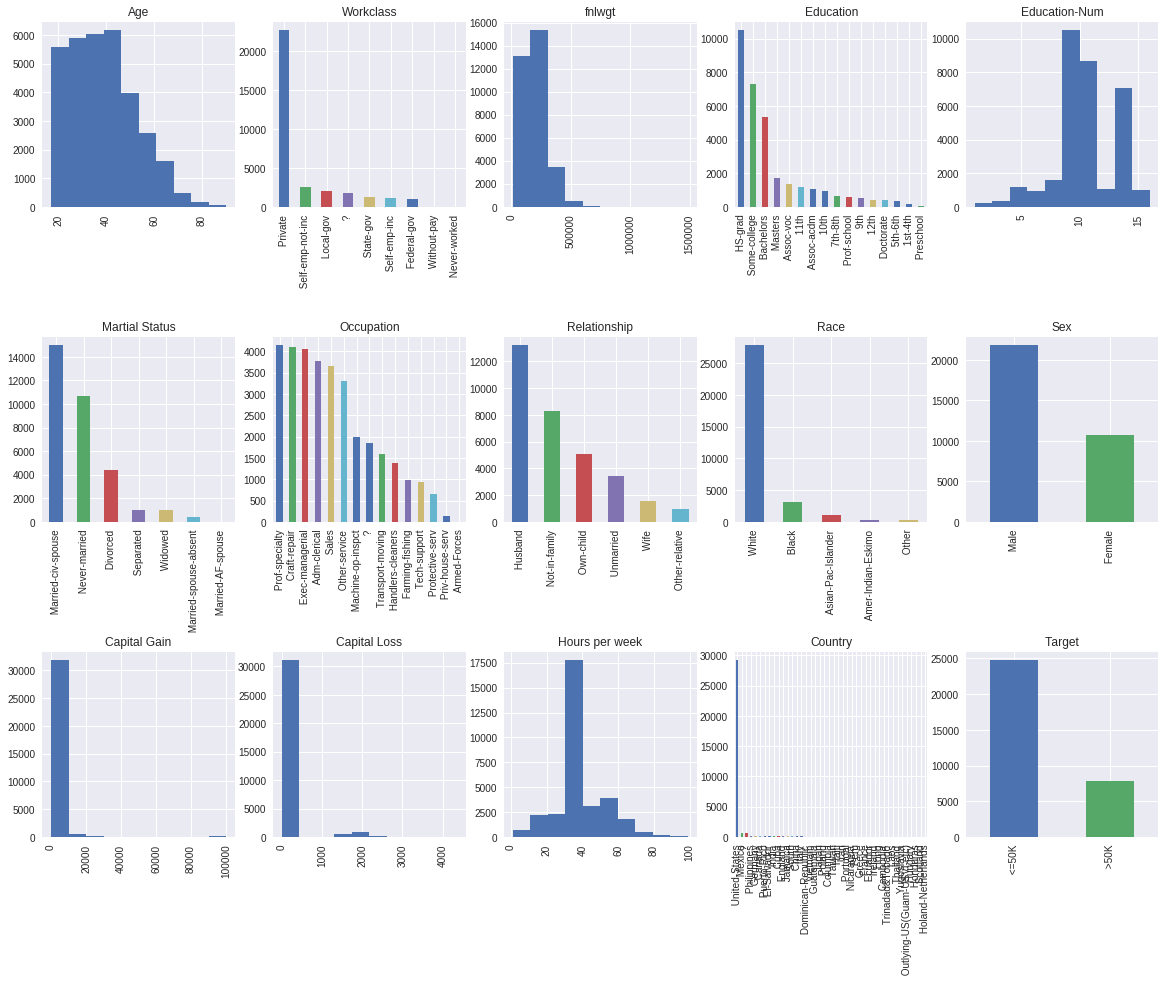

In [111]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = ceil(float(train_df.shape[1]) / cols)
for i, column in enumerate(train_df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if train_df.dtypes[column] == np.object:
        train_df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        train_df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

# Data pre-process

## Mark 'Target' to 0 or 1

In [0]:
# The benefit of as_index=True is that you can yank out the rows you want by using key names. 
train_df['Target'].replace(to_replace={' <=50K': -1},inplace=True)
train_df['Target'].replace(to_replace={' >50K': 1}, inplace=True)

# The benefit of as_index=True is that you can yank out the rows you want by using key names. 
test_df['Target'].replace(to_replace={' <=50K.': -1},inplace=True)
test_df['Target'].replace(to_replace={' >50K.': 1}, inplace=True)

## Data Processing
Because 'Education' and 'Education-Num' are represented the same feature.

In [0]:
data_preprocess = True
if data_preprocess == True:
  del train_df['Education']
  del test_df['Education']
  
  combine = [train_df, test_df]
  
  train_df['AgeBand'] = pd.cut(train_df['Age'], 5)  #80/5=16
  train_df[['AgeBand', 'Target']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
                                                                                           
  test_df['AgeBand'] = pd.cut(test_df['Age'], 5)  #80/5=16
  test_df[['AgeBand', 'Target']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
 
  for dataset in combine:
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 47), 'Age'] = 1
    dataset.loc[ (dataset['Age'] > 47) & (dataset['Age'] <= 60), 'Age'] = 2
    dataset.loc[ (dataset['Age'] > 60) & (dataset['Age'] <= 75), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 75, 'Age'] = 4

  train_df = train_df.drop(['AgeBand'], axis=1)
  test_df = test_df.drop(['AgeBand'], axis=1)
    
  combine = [train_df, test_df]
  
  train_df['fBand'] = pd.cut(train_df['fnlwgt'], 5)  #80/5=16
  train_df[['fBand', 'Target']].groupby(['fBand'], as_index=False).mean().sort_values(by='fBand', ascending=True)
                                                                                           
  test_df['fBand'] = pd.cut(test_df['fnlwgt'], 5)  #80/5=16
  test_df[['fBand', 'Target']].groupby(['fBand'], as_index=False).mean().sort_values(by='fBand', ascending=True)
 
  for dataset in combine:
    dataset.loc[ (dataset['fnlwgt'] > 10000) & (dataset['fnlwgt'] <= 300000), 'fnlwgt'] = 0
    dataset.loc[ (dataset['fnlwgt'] > 300000) & (dataset['fnlwgt'] <= 600000), 'fnlwgt'] = 1
    dataset.loc[ (dataset['fnlwgt'] > 600000) & (dataset['fnlwgt'] <= 900000), 'fnlwgt'] = 2
    dataset.loc[ (dataset['fnlwgt'] > 900000) & (dataset['fnlwgt'] <= 1200000), 'fnlwgt'] = 3
    dataset.loc[ dataset['fnlwgt'] > 1200000, 'fnlwgt'] = 4
  
  train_df = train_df.drop(['fBand'], axis=1)
  test_df = test_df.drop(['fBand'], axis=1)
    
  combine = [train_df, test_df]
  
  train_df['hpwBand'] = pd.cut(train_df['Hours per week'], 5)  #80/5=16
  train_df[['hpwBand', 'Target']].groupby(['hpwBand'], as_index=False).mean().sort_values(by='hpwBand', ascending=True)
                                                                                           
  test_df['hpwBand'] = pd.cut(test_df['Hours per week'], 5)  #80/5=16
  test_df[['hpwBand', 'Target']].groupby(['hpwBand'], as_index=False).mean().sort_values(by='hpwBand', ascending=True)
 
  for dataset in combine:
    dataset.loc[ (dataset['Hours per week'] <= 20), 'Hours per week'] = 0
    dataset.loc[ (dataset['Hours per week'] > 20) & (dataset['Hours per week'] <= 40), 'Hours per week'] = 1
    dataset.loc[ (dataset['Hours per week'] > 40) & (dataset['Hours per week'] <= 60), 'Hours per week'] = 2
    dataset.loc[ (dataset['Hours per week'] > 60) & (dataset['Hours per week'] <= 80), 'Hours per week'] = 3
    dataset.loc[ dataset['Hours per week'] > 80, 'Hours per week'] = 4

  train_df = train_df.drop(['hpwBand'], axis=1)
  test_df = test_df.drop(['hpwBand'], axis=1)
    
  combine = [train_df, test_df]

## Encode the categorical features as numbers

In [0]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #encoders[column] = preprocessing.OneHotEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


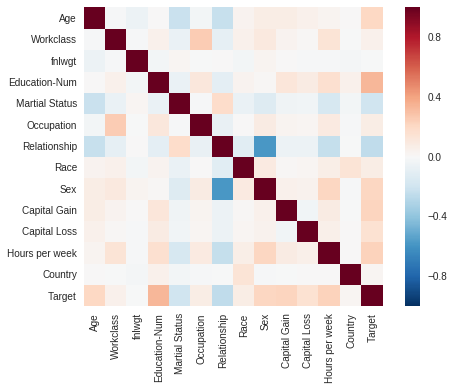

In [115]:
# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(train_df)
encoded_test, _ = number_encode_features(test_df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

In [116]:
#import sklearn.cross_validation as cross_validation
data = encoded_data.drop(['Target'],axis=1,inplace=False)
label = encoded_data['Target']

X_train, X_valid, y_train, y_valid = train_test_split(data, label, train_size=0.70)   

X_test = encoded_test.drop(['Target'],axis=1,inplace=False)
y_test = encoded_test['Target']

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(22792, 13) (22792,)
(9769, 13) (9769,)
(16281, 13) (16281,)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Scaler

In [117]:
'''
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid = scaler.transform(X_valid)
'''

'\nscaler = preprocessing.StandardScaler()\nX_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)\nX_valid = scaler.transform(X_valid)\n'

# Load Adult Income dataset

In [118]:
income_dataset = np.concatenate((np.array(data), np.array(label).reshape(-1, 1)), axis = 1)
income_dataset_test = np.concatenate((np.array(X_test), np.array(y_test).reshape(-1, 1)), axis = 1)
print(income_dataset.shape, data.shape, label.shape)
print(income_dataset_test.shape)

(32561, 14) (32561, 13) (32561,)
(16281, 14)


In [119]:
print(income_dataset[:2])
np.savetxt('encoder.txt',income_dataset)

[[   1    7    0   13    4    1    1    4    1 2174    0    1   39   -1]
 [   2    6    0   13    2    4    0    4    1    0    0    0   39   -1]]


# Load Fashion_MNIST dataset

In [120]:
import utils.mnist_reader as mnist_reader
from utils import mnist_reader
XM_train, YM_train = mnist_reader.load_mnist('data-FM/fashion', kind='train')
XM_test, YM_test = mnist_reader.load_mnist('data-FM/fashion', kind='t10k')

print(XM_train.shape)
dataset_mnist_test = np.concatenate((XM_test, YM_test.reshape(-1,1)), axis = 1)
dataset_mnist = np.concatenate((XM_train, YM_train.reshape(-1,1)), axis = 1)

(60000, 784)


# Auto Bat

In [0]:
from sklearn.naive_bayes import GaussianNB

def analysis_pred(y_true, y_pred):
    acc = np.mean(y_true == y_pred)
    print("The accuracy is {:.2%}".format(acc))
    uni = np.unique(y_true)
    if uni.shape[0] == 2: # Adult income dataset
        f1_score = metrics.f1_score(y_true, y_pred)
        print("F1 score: {:.3f}".format(f1_score))
        print("classification report:")
        print(classification_report(y_true, y_pred))


def run_model_on_dataset(model_name, dataset_name, dataset, test_dataset, params, n_split = 0.7):
    print("training model:{} on dataset:{}".format(model_name, dataset_name))
    print("-"*50)
    n_total_set = dataset.shape[0]
    n_train = int(n_split * n_total_set)
    
    train_set = dataset[:n_train,:]
    valid_set = dataset[n_train:,:]
    
    X_train, y_train = train_set[:,:-1], train_set[:,-1]
    X_valid, y_valid = valid_set[:,:-1], valid_set[:,-1]
    X_test, y_test = test_dataset[:,:-1], test_dataset[:, -1]
    
    '''
    scaler = preprocessing.StandardScaler()
    
    X_train = scaler.fit(X_train)
    X_valid = scaler.fit(X_valid)
    X_test = scaler.fit(X_test)
    '''
    
    model = None
    if model_name == "NB":
        model = GaussianNB()
    elif model_name == "SVM":
        #model = SVC(C = params["C"], gamma = params["gamma"], max_iter = 1000, kernel = params["kernel"], verbose = True)
        model = SVC(C = params["C"], gamma = params["gamma"], 
                    kernel = params["kernel"], verbose = True)
    else:
        model = MLPClassifier(
            hidden_layer_sizes = params["hidden_layer_sizes"], max_iter = 2000, 
            verbose = False, early_stopping = True)
    print("fitting train_set...")
    model.fit(X_train, y_train)
    print("report on test set:")
    #print("predicting train_X")
    #y_pred_train = model.predict(X_train)
    #analysis_pred(y_train, y_pred_train)
    #print("predicting valid_X")
    #y_pred_valid = model.predict(X_valid)
    #analysis_pred(y_valid, y_pred_valid)  
    y_pred_test = model.predict(X_test)
    analysis_pred(y_test, y_pred_test)
    print("======= end of model:{} on dataset:{} ============\n".format(model_name, dataset_name))

In [122]:
'''
income_dataset = MinMaxScaler().fit_transform(income_dataset)
income_dataset_test = MinMaxScaler().fit_transform(income_dataset_test)
'''

'\nincome_dataset = MinMaxScaler().fit_transform(income_dataset)\nincome_dataset_test = MinMaxScaler().fit_transform(income_dataset_test)\n'

In [0]:

model_names = ["NB", "SVM", "MLP"]
dataset_names = ["adult_income", "fashion_mnist"]#, "adult_income"]
datasets = {"adult_income": income_dataset, "fashion_mnist": dataset_mnist}
datasets_test = {"adult_income": income_dataset_test, "fashion_mnist": dataset_mnist_test}
params_dict = {
    "SVM_fashion_mnist":(
        #{"C": 1000 , "gamma": 1e-6, "kernel": "rbf"}, 
        # add your training hyper-parameter settings here for SVM
    ),
    "SVM_adult_income":(
        {"C": 100 , "gamma": 1e-6, "kernel": "rbf"}, 
    ),
    "MLP_fashion_mnist":(
        #{"hidden_layer_sizes": (1024)},
        #{"hidden_layer_sizes": (512, 256)},
        
        # add your training hyper-parameter settings here for MLP
    ),
    "MLP_adult_income": (
        {"hidden_layer_sizes": (16, 4)},
    ),
    "NB_adult_income":({"kernel":'rbf'}),
    "NB_fashion_mnist":(
        # {"kernel":'rbf'}
    )
}

In [124]:
for model_name in model_names:
    for dataset_name in dataset_names:
        key = model_name + "_" + dataset_name  
        if params_dict[key] is not None:
            for params in params_dict[key]:
                print(model_name, dataset_name, params)
                run_model_on_dataset(
                    model_name, dataset_name, datasets[dataset_name], 
                    datasets_test[dataset_name], params, n_split = 0.99)


NB adult_income kernel
training model:NB on dataset:adult_income
--------------------------------------------------
fitting train_set...
report on test set:
The accuracy is 79.88%
F1 score: 0.423
classification report:
             precision    recall  f1-score   support

         -1       0.82      0.95      0.88     12435
          1       0.66      0.31      0.42      3846

avg / total       0.78      0.80      0.77     16281

======= end of model:NB on dataset:adult_income ============

SVM adult_income {'C': 100, 'gamma': 1e-06, 'kernel': 'rbf'}
training model:SVM on dataset:adult_income
--------------------------------------------------
fitting train_set...
[LibSVM]report on test set:
The accuracy is 81.91%
F1 score: 0.432
classification report:
             precision    recall  f1-score   support

         -1       0.82      0.98      0.89     12435
          1       0.84      0.29      0.43      3846

avg / total       0.82      0.82      0.78     16281

======= end of model:SV